# Semi Supervised Gender Voice Classification

## Introduction

In the advanced solution, I chose to present a solution that I personally faced during exploring the dataset. Originally, I wanted to do a regular supervised model that classifies the gender based on the voice. I checked the dataset, and I found that we have 184 participants, so I throught, hmmm, I can listen to an audio sample for each participant and label their genders, and then for each audio I can label them using a code snippet based on the labeled participant.
However, after half though the labeling process, I found out the participant id is not unique.


As a result, I got another idea, I would label a small balanced subset of females and males, then fit a model using this subset and finally predict the rest using an ML model.

This is called <font color=green>Semi Supervised Learning</font>, and here is the methodology:


I will be using 5000 samples of the MLEnd dataset, out of the 5000, 1820 are manually labeled (Supervised), the rest are unlabelled (Unsupervised).


For the supervised part, we should be able to identify what useful information (<font color=green>audio features</font>) which should be extracted to help us in our mission.
After extracting the data, we proceed with the next step which is <font color=green>*feature selection*</font>. We can perform statistical analysis and data visualization to help us understand if there is a correlation between the extracted features and check if the classes are *linearly separable*, which is not always an easy task.
These techniques can also help us to choose which features to use as **predictors** in our classifier, and also may reduce dimensionality if we pick less features.
Once we have the predictors prepared, we need to examine their value ranges, as sometimes we need to scale them as a <font color=green>preprocessing</font> step, this can be achieved using techniques such as normalization and standardization.

To perform a semi supervised learning, I used <font color=green>Label Spreading</font> model.

We fit our model using a subset of the labeled data as lebeled, and the rest will be treated as unlabeled, the model then will use labels distribution to fit the unlabeled data.

To evaluate the model, we can only evaluate the supervised part, using <font color=green>accuracy</font> quality metric and confusion matrix.

The final result was 40% accuracy.

In [190]:
# import and dataset initialization
import glob

import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import seaborn as sns
from IPython.display import display, HTML
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report, plot_roc_curve
from sklearn.semi_supervised import LabelSpreading
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

plt.style.context('fivethirtyeight')
plt.style.use('fivethirtyeight')

MLEnd_dir = 'Data/MLEnd'
FEATURE_DIR = 'ExtractedFeatures/ExtendedTrim'
AUDIO_DIR = 'Data/MLEnd/training'

FILE_ID = 'File ID'
DIGIT_LABEL = 'digit_label'
PARTICIPANT = 'participant'
INTONATION = 'intonation'
GENDER = 'gender'
LABEL_COLUMN = '# label'

MALE_LABEL = 'male'
FEMALE_LABEL = 'female'
LABELS =  [MALE_LABEL, FEMALE_LABEL]
GENDER_LABELS = {}
for i in range(len(LABELS)):
    GENDER_LABELS[LABELS[i]] = i

files = glob.glob(f'{MLEnd_dir}/training/*.wav')

def display_waveplot(x, sr, gender):
    plt.figure(figsize=(10, 3))
    plt.title(f'{gender} Waveplot', size=15)
    librosa.display.waveplot(x, sr=sr)
    plt.show()

def display_spectrogram(x, sr, gender):
    # convert signal using fourier transform
    X = librosa.stft(x)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title(f'{gender} Spectrogram', size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()
    plt.show()

def load_trimmed_audio(file_path, sr=None):
    x, sr = librosa.load(file_path, sr=sr)
    x, _ = librosa.effects.trim(x, top_db=25)
    return x, sr

mainset_df = pd.read_csv(f'{MLEnd_dir}/trainingMLEnd_gender.csv')
N_SAMPLES = 5000
dataset_df = mainset_df.iloc[:N_SAMPLES, :]

## MLEnd Dataset

We are using MLEnd dataset which consists 20k records of four information, file_id, digit_label, intonation_label and participant_id.

I added a new label which is the gender, I will work on only 5000 records. I have manually labeled 1815 samples.

Our task is about the classifying audios into two categories, [<font color=green>Female</font>, <font color=ligtblue>Male</font>]

### data presentation

In [191]:
dataset_df.tail()

,File ID,digit_label,participant,intonation,gender
4995,0004995.wav,100,S138,bored,female
4996,0004996.wav,15,S162,excited,male
4997,0004997.wav,10,S40,bored,NaN
4998,0004998.wav,18,S168,excited,NaN
4999,0004999.wav,7,S10,excited,male


Male: 891
Female: 924
Total labeled : 1815

Total unlabeled : 3185

Percentage_labeled: 36.3%
Percentage_unlabeled: 63.7%


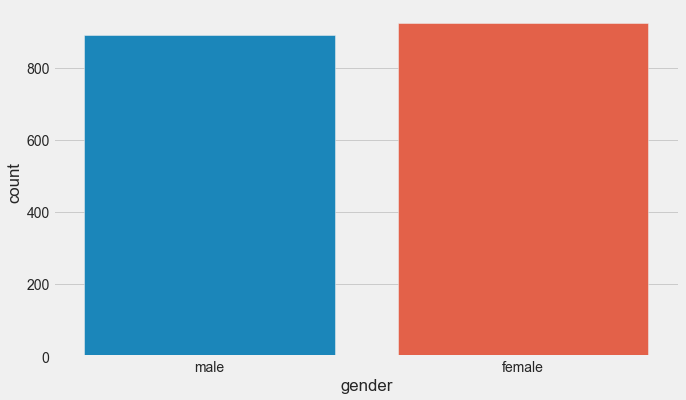

In [192]:
male_df = dataset_df.loc[dataset_df[GENDER] == MALE_LABEL]
female_df = dataset_df.loc[dataset_df[GENDER] == FEMALE_LABEL]

total_labeled_male = len(male_df)
total_labeled_female = len(female_df)
total_unlabeled = dataset_df[[GENDER]].isna().sum()[0]

print(f'Male: {total_labeled_male}')
print(f'Female: {total_labeled_female}')
print(f"Total labeled : {total_labeled_male+total_labeled_female}\n")
print(f"Total unlabeled : {total_unlabeled}\n")

print(f"Percentage_labeled: {(100*(total_labeled_male+total_labeled_female)/N_SAMPLES)}%")
print(f"Percentage_unlabeled: {(100*total_unlabeled/N_SAMPLES)}%")

plt.figure(figsize=(10,6))
sns.countplot(x=GENDER, data=dataset_df );

I tried to label balanced amount for each gender, to avoid bias.


Now let's prepare the new dataset, with the extracted audio features. But first, we need to know what features to extract.

## Exploring Audio Data


Raw audios need to be processed by extracting relevant information so that you can use it in our classifier.

This section is relatively long, only to explain how are these chosen features related to our classification problem.

Most of the plots code snippets are inspired mostly from Librosa and some kaggle kernel notes, I will be mentioning thm at the end.


Now let's get comfortable with audio data, we can plot an audio in two domains:
#### 1. *Waveplot*
Representing audio signal in time domain using sample rate, showing the amplitude (loudness) of the audio at a given time.

Side note: LibRosa normalizes the amplitude that is why we will see the y-axis represents normalized amplitiude between -1 and 1.

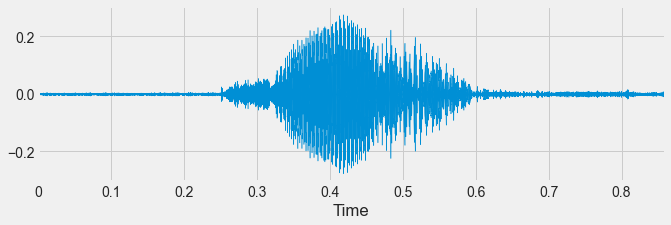

In [193]:
# load sample and plot the wave in time
file_path = f"{AUDIO_DIR}/{male_df.iloc[1][FILE_ID]}"
x, sr = librosa.load(file_path)
plt.figure(figsize=(10, 3))
librosa.display.waveplot(x, sr=sr,);

The first thing I've noticed is the leading and trailing silence. So let's get rid of them.

Trimming will reduce further computation when we perform feature extraction, and we will end up with less irrelevant data.

I am using 25 db (20 db is rustling leaves and 30 db is whispering) as a threshold to cut-off where the silence begins and ends.

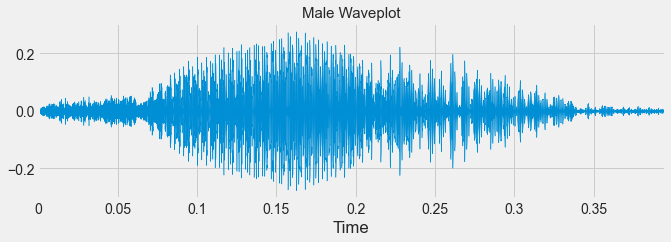

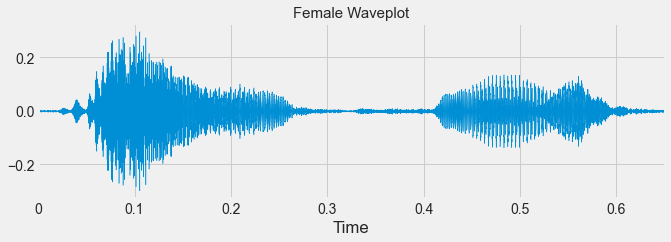

In [194]:
# trimming audio using LibRosa.
file_path = f"{AUDIO_DIR}/{male_df.iloc[4][FILE_ID]}"
display(ipd.Audio(file_path))
x_male, _ = librosa.effects.trim(x, top_db=25)
display_waveplot(x_male, sr, 'Male')

file_path = f"{AUDIO_DIR}/{female_df.iloc[14][FILE_ID]}"
display(ipd.Audio(file_path))
x_female,sr = load_trimmed_audio(file_path)
display_waveplot(x_female, sr, 'Female')


The signal extracted from the audios is definitely not sufficient to identify features and characteristics of each different intonation.

#### 2. *Spectrogram*

Moving to frequency domain, we represent an audio using spectrogram which displays changes in the frequencies in a signal over time.
Amplitude is then represented on a third dimension with variable brightness or color (the right-side vertical bar in dB is an amplitude indicator).


Let's plot the spectrogram for the same four audios and compare.

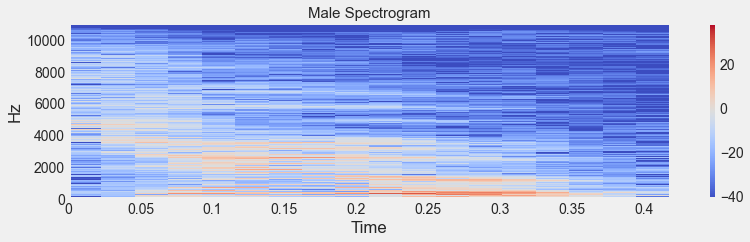

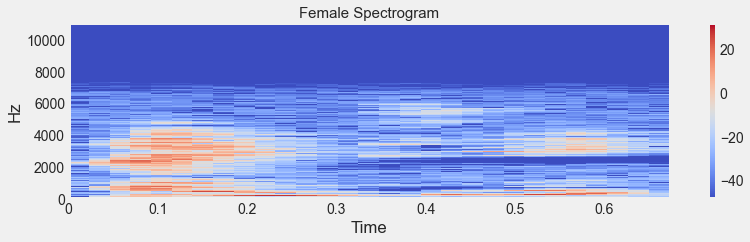

In [195]:
display_spectrogram(x_male, sr, 'Male')
display_spectrogram(x_female, sr, 'Female')

A male audio is showing higher amplitudes a female audio, alstough women have higher pitch.


## Audio Features Extractions

In this section, I'm sharing the process of identifying good audio features that will help us in this ML problem.

#### *Fundamental Frequency*
The fundamental frequency **F0** is the frequency at which vocal cords vibrate in voiced sounds.

In [196]:
def display_pitch(X, sr, gender):
    winLen=0.02
    p = winLen * sr
    hop_length = 512
    frame_length = int(2 ** int(p - 1).bit_length())
    f0, voiced_flag, _ = librosa.pyin(y=X, fmin=80, fmax=450, sr=sr, frame_length=frame_length,
                                      hop_length=hop_length)
    times = librosa.times_like(f0)

    # get amplitudes of the audio
    D = librosa.amplitude_to_db(np.abs(librosa.stft(X)), ref=np.max)

    # plt.figure(figsize=(10, 3))
    fig, ax = plt.subplots()
    img = librosa.display.specshow(D, x_axis='time', y_axis='log', ax=ax)
    plt.title(f'fundamental frequency estimation for {gender} audio')
    fig.colorbar(img, ax=ax, format="%+2.f dB")
    ax.plot(times, f0, label='f0', color='cyan', linewidth=3)
    ax.legend(loc='upper right')
    plt.show();

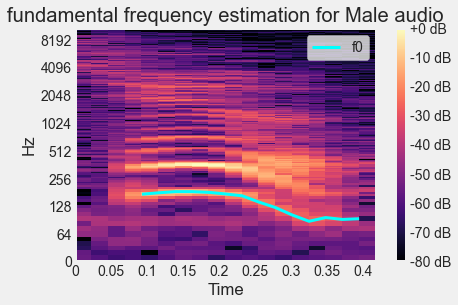

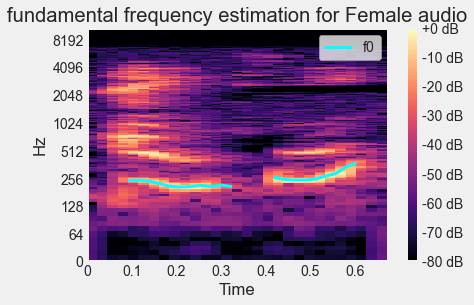

In [197]:
display_pitch(x_male, sr, 'Male')
display_pitch(x_female, sr, 'Female')

#### *MFCCs*
**Mel-frequency cepstral** coefficients concisely describe the overall shape of a spectral envelope, representing the characteristics of human voice, making them excellent information for speech-related tasks.


MFCC is computed using Mel filter-bank. These filters are typically narrower around 0Hz and wider for higher frequencies.

As you can see in the following plot.

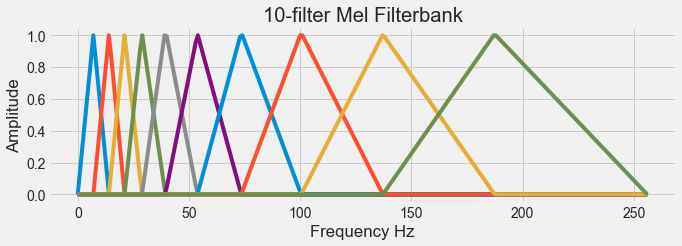

In [198]:
path = f"{AUDIO_DIR}/{dataset_df.iloc[745][FILE_ID]}"
x_, sr = load_trimmed_audio(path)
# get mfcc
mfcc_ = librosa.feature.mfcc(y=x_, sr=sr)
# get Mel filter-bank matrix, librosa normalizes the matrix
mel_basis = librosa.filters.mel(sr=sr, n_fft=512, n_mels=10,fmin=0, fmax=sr / 2)
# transform the normalized matrix into equal height, dividing by the max of each row
mel_basis /= np.array(np.max(mel_basis, axis=1), ndmin=2).T

plt.figure(figsize=(10, 3))
plt.xlabel('Frequency Hz')
plt.ylabel('Amplitude')
plt.title('10-filter Mel Filterbank')
plt.plot(mel_basis.T)
plt.show()

This means that we have very good resolution in low frequencies, the opposite is true for higher frequencies.  So the most of the information is located in lower frequencies (i.e. formants). Therefore, in speech recognition we mostly use the 12-13 lower values.

Let's compare the **mean of 13 coefficients** for females enunciating the number *11*

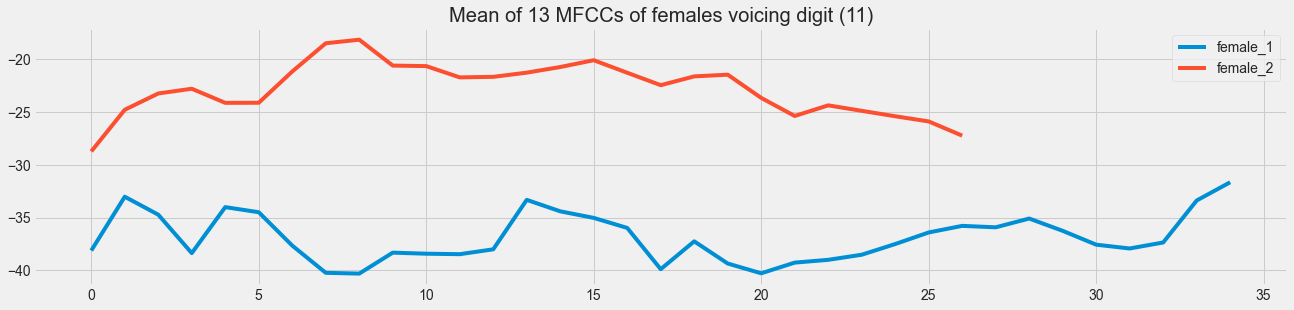

In [199]:
# load the first audio, extract 20 mfcc and compute there means
path = f"{AUDIO_DIR}/{dataset_df.iloc[61][FILE_ID]}"
x_female_1, sr = load_trimmed_audio(path)
mfcc_1 = np.mean(librosa.feature.mfcc(y=x_female_1, sr=sr, n_mfcc=13), axis=0)
display(HTML(f'<h6">female_1</h6>'), ipd.Audio(path))

# load the second audio, extract 20 mfcc and compute there means
path = f"{AUDIO_DIR}/{dataset_df.iloc[4377][FILE_ID]}"
x_female_2, sr = load_trimmed_audio(path)
mfcc_2 = np.mean(librosa.feature.mfcc(y=x_female_2, sr=sr, n_mfcc=13), axis=0)
display(HTML(f'<h6">female_2</h6>'), ipd.Audio(path))

# plot the 2 mfccs
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
plt.plot(mfcc_1, label=f'{dataset_df.iloc[61][GENDER]}_1')
plt.plot(mfcc_2, label=f'{dataset_df.iloc[4377][GENDER]}_2')
plt.title('Mean of 13 MFCCs of females voicing digit (11)')
plt.legend()
plt.show()

Using MFCC is a good feature to differentiate the gender and emotions as demonstrated above. Even thou we've ommited alot of good information by just taking the mean, it seems we still capture enough to be able to see some difference. Whether this difference is significant for distinguishing the variou emotions, we'll find out in the next part where we will create a baseline emotion classifier



Both have differenct tones, this is real example how mfcc charactarize the voice.
Now let's see a plot for four different tones voicing the digit *1*.

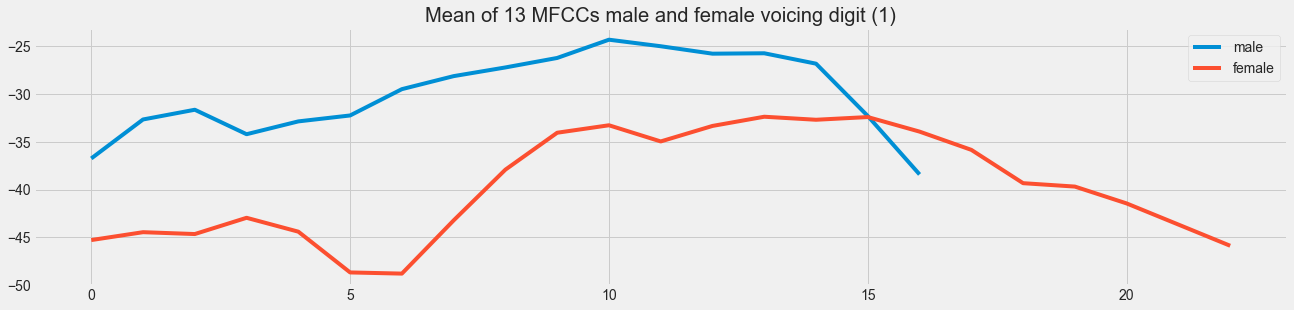

In [200]:
# Male MFCC
path = f"{AUDIO_DIR}/{dataset_df.iloc[804][FILE_ID]}"
X, sr = load_trimmed_audio(path)
male_1 = np.mean(librosa.feature.mfcc(y=X, sr=sr, n_mfcc=13), axis=0)
display(HTML(f'<h6">Male</h6>'), ipd.Audio(path))

# Female MFCC
path = f"{AUDIO_DIR}/{dataset_df.iloc[1149][FILE_ID]}"
X, sr = load_trimmed_audio(path)
female_1 = np.mean(librosa.feature.mfcc(y=X, sr=sr, n_mfcc=13), axis=0)
display(HTML(f'<h6">Female</h6>'), ipd.Audio(path))

# Plot the two audio waves together
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
plt.subplot(3,1,1)
plt.plot(male_1, label='male')
plt.plot(female_1, label='female')
plt.title('Mean of 13 MFCCs male and female voicing digit (1)')
plt.legend()
plt.show()

For the same voiced word "**one**", male voice is having a higher values, since MFCC is a good feature to differentiate emotions/tones and pitch as demonstrated above.


#### *Root Mean Square Energy*

The RMS Energy (RMSE) is simply the square root of the mean squared amplitude over a time window.

We can see that the male audio has more energy/ amplitude.

In [201]:
def display_rms_energy(X, sr, tone):
    frame_length=2048
    hop_length=512
    # compute sum of signal square by frame
    energy = np.array([
        sum(abs(X[i:i+frame_length]**2))
        for i in range(0, len(X), hop_length)
    ])
    # compute RMS
    rmse = librosa.feature.rms(X)
    # plot energy and rmse along the waveform
    frames = range(len(energy))
    t = librosa.frames_to_time(frames, sr=sr, hop_length=hop_length)
    plt.figure(figsize=(10, 2))
    plt.title(f'RMSE {tone}')
    librosa.display.waveplot(X, sr=sr, alpha=0.4)
    # normalized for visualization
    plt.plot(t, energy/energy.max(), 'r--')
    # normalized for visualization
    plt.plot(t[:len(rmse)], rmse/rmse.max(), color='blue')
    plt.legend(('Energy', 'RMSE'))
    plt.show()

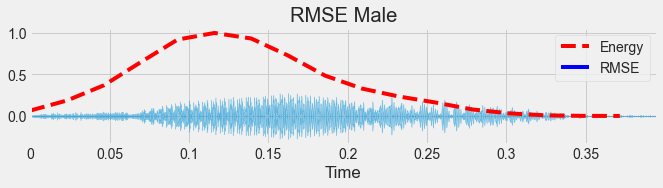

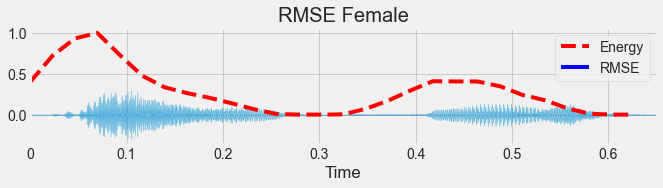

In [202]:
display_rms_energy(x_male, sr, 'Male')
display_rms_energy(x_female, sr, 'Female')

#### *Zero Crossing Rate*
The rate of sign-changes of the signal during the duration of a particular frame, making it a key feature to classify percussive sounds and the simplest method to distinguish between voiced and unvoiced speech.

However, this feature is highly dependant on the length of the audio.

In [203]:
total_zero_crossing_male = np.sum(librosa.zero_crossings(y=x_male))
total_zero_crossing_female = np.sum(librosa.zero_crossings(y=x_female))

print(f"Number of zero crossings in Male audio is {total_zero_crossing_male}")
print(f"Number of zero crossings in Female audio is {total_zero_crossing_female}")

Number of zero crossings in Male audio is 938
Number of zero crossings in Female audio is 1682


In [204]:
def plot_spectral_features(spectral_feature, tone):
    # Computing the time variable for visualization
    frames = range(len(spectral_feature))
    # Converts frame counts to time (seconds)
    t = librosa.frames_to_time(frames)
    #Plotting the Spectral Centroid along the waveform
    plt.plot(t, sklearn.preprocessing.minmax_scale(spectral_feature), label=tone)

#### *Chroma Features*
A.K.A *chromagram*, is referred to as “<font color="green">**pitch class profile**</font>”, which is used to extract 12-element representation of spectral energy called **chroma vector**.

Pitch class profile are majorly used for analyzing music, in our case, we need it to analyze tones or emotions.

Notice how the profiles differ for each class in the following plots.


In [205]:
def display_chromagram(X, sr, tone):
    chromagram = librosa.feature.chroma_stft(X, sr=sr, hop_length=5000)
    plt.figure(figsize=(10, 3))
    plt.title(f'chromagram {tone}')
    librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=5000, cmap='coolwarm')
    plt.show()

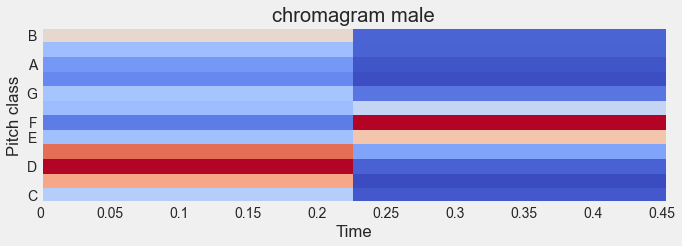

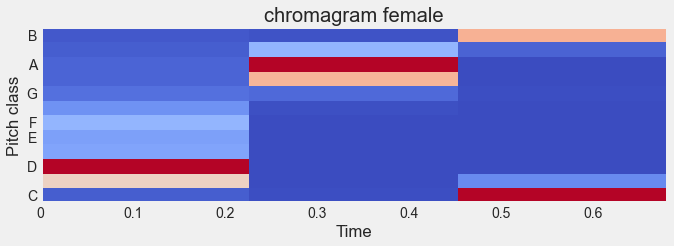

In [206]:
display_chromagram(x_male, sr, 'male')
display_chromagram(x_female, sr, 'female')


#### *Harmony and Percussion*
Harmonics are characteristics that human years can't distinguish (represents the sound color)
Percussion understanding shock wave represents the sound rhythm and emotion.

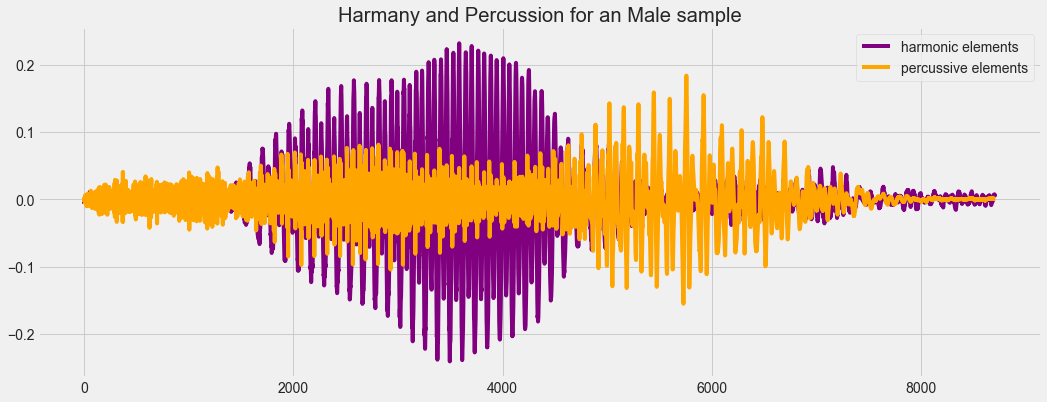

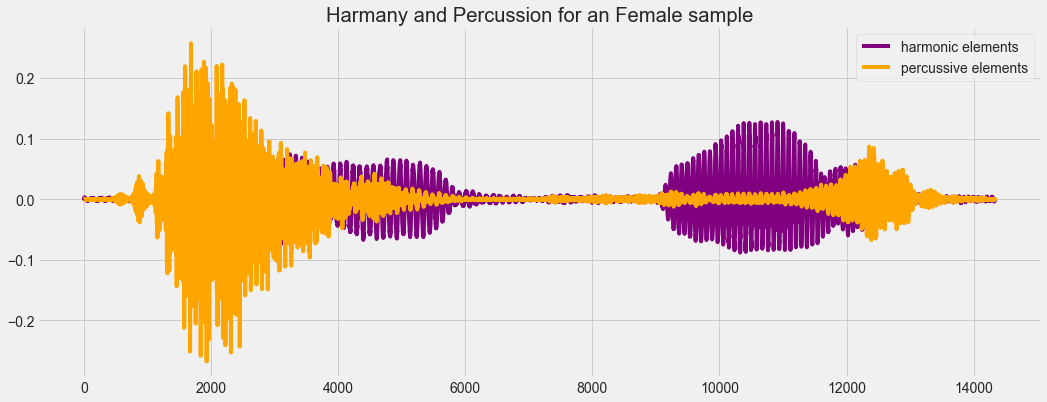

In [207]:
def plot_harmony(X, gender):
    y_harm, y_perc = librosa.effects.hpss(X)
    plt.figure(figsize = (16, 6))
    plt.title(f'Harmany and Percussion for an {gender} sample')
    plt.plot(y_harm, color='purple', label='harmonic elements');
    plt.plot(y_perc, color='orange', label='percussive elements');
    plt.legend()
    plt.show()
plot_harmony(x_male, 'Male')
plot_harmony(x_female, 'Female')

#### *Spectral Rolloff*
The roll-off is the frequency below which 85% of accumulated spectral magnitude is concentrated.

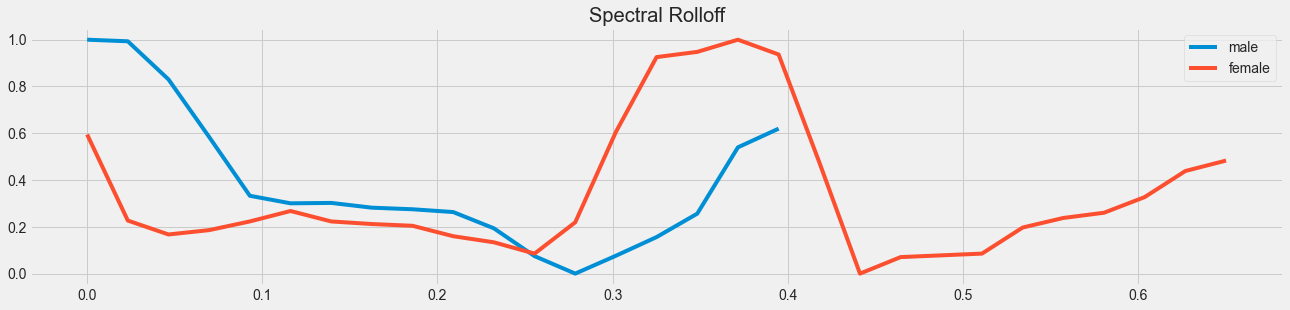

In [208]:
# get the rolloff vector
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
spectral_rolloff = librosa.feature.spectral_rolloff(x_male, sr=sr)[0]
plot_spectral_features(spectral_rolloff, 'male')
spectral_rolloff = librosa.feature.spectral_rolloff(x_female, sr=sr)[0]
plot_spectral_features(spectral_rolloff, 'female')
plt.title(f'Spectral Rolloff')
plt.legend()
plt.show()

I am also using other spectral features (centroid, flatness, contrast and bandwidth).


## Dataset Preparation

Now that we settled on which features to extract, we need to think if the audios need preprocessing before the extraction.

I have already mentioned the trimming part, since it will save us lots of time and calculation, not to mention reducing irrelevant data.

Here are the script to extract the <font color=green>**mean & standard deviation**</font> of each mentioned feature using LibRosa for the 5K preprocessed (trimmed) audios.

The features are saved along with their corresponding labels in a csv file.

Expand the next cell if you are interested.

In [209]:
def extract_features(data, sample_rate, winLen=0.02):
    """
    Extracted the listed audio features below from an audio signal

    :param data: audio signal
    :param sample_rate: sampling rate at which the data signal was sampled at
    :param winLen: desired window length to calculate fundamental frequency
    :return: tuple of list of teh names of features (header) and the extracted features array
    """
    result = np.array([])
    headers = []

    # Fundamental Frequency
    p = winLen * sample_rate
    frame_length = int(2 ** int(p - 1).bit_length())
    hop_length = frame_length // 2
    f0, voiced_probs, _ = librosa.pyin(y=data, fmin=80, fmax=450, sr=sample_rate, frame_length=frame_length, hop_length=hop_length)
    pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0)) < 1 else 0
    pitch_std = np.nanstd(f0) if np.mean(np.isnan(f0)) < 1 else 0
    headers.extend(['pitch_mean', 'pitch_std'])
    result = np.hstack((result, pitch_mean, pitch_std))

    # Root Mean Square Value
    rms = librosa.feature.rms(y=data)
    headers.extend(['RMS_energy_mean', 'RMS_energy_std'])
    result = np.hstack((result, np.mean(rms), np.std(rms)))

    # ZCR
    zcr = librosa.feature.zero_crossing_rate(y=data)
    headers.extend(['zero_crossing_rate_mean', 'zero_crossing_rate_std'])
    result = np.hstack((result, np.mean(zcr), np.std(zcr)))

    # Chroma
    stft = np.abs(librosa.stft(data))
    chroma_stft = librosa.feature.chroma_stft(S=stft, sr=sample_rate)[0]
    headers.extend(['chroma_mean', 'chroma_std'])
    result = np.hstack((result, np.mean(chroma_stft), np.std(chroma_stft)))

   # Rolloff
    rolloff = librosa.feature.spectral_rolloff(y=data, sr=sample_rate)[0]
    headers.extend([f'rolloff_mean', 'rolloff_std'])
    result = np.hstack((result, np.mean(rolloff), np.std(rolloff)))

    # MFCC
    mfcc = librosa.feature.mfcc(y=data, sr=sample_rate)
    for _i in range(1, len(mfcc) + 1):
        headers.extend([f'mfcc_mean_{_i}', f'mfcc_std_{_i}'])
        result = np.hstack((result, np.mean(mfcc), np.std(mfcc)))

    # Harmony and Percussion
    y_harm, y_perc = librosa.effects.hpss(data)
    headers.extend(['harm_mean', 'harm_std', 'perc_mean', 'perc_std'])
    result = np.hstack((result, np.mean(y_harm), np.std(y_harm), np.mean(y_perc), np.std(y_perc)))
    return headers, result

def preprocess_date(files_list, ml_end_df, trim=False, emphasise=False, scale_audio=False, sampling_rate=None):
    """
    Extract features for the passed audio files with the required preprocessing method

    :param files_list: list of paths of audio files
    :param ml_end_df: MLEnd dataset (pandas dataframe)
    :param trim: True if we want to trim the audios first
    :param emphasise: True if we want to emphasise the audios first
    :param scale_audio: True if we want to scale up the audios first
    :param sampling_rate: if not used 22050 Hz will be used as default
    :return: tuple of headers array that will be used for csv file, features array and labels array
    """
    features, labels = [], []
    for file in tqdm(files_list):
        file_id = file.split('/')[-1]
        y_intonation = ml_end_df.loc[ml_end_df[FILE_ID] == file_id][GENDER].iloc[0]
        # extract the intonation label from the dataset and encode it to a corresponding number [0, 1, 2, 3]
        yi = GENDER_LABELS[y_intonation]
        data, sampling_rate = librosa.load(file, sr=sampling_rate)
        # preprocess, trim audio leading and trailing silence at 25db
        if trim:
            data, index = librosa.effects.trim(data)
        # preprocess, emphasise audio
        if emphasise:
            data = librosa.effects.preemphasis(data)
        # preprocess, scale up the audio
        if scale_audio:
            data = data / np.max(np.abs(data))
        headers, xi = extract_features(data=data, sample_rate=sampling_rate)
        features.append(xi)
        labels.append(yi)
    headers.insert(0, 'label')
    return headers, np.array(features), np.array(labels)

def extract_and_save_features(dir_path, files_list, ml_end_df,  trim, emphasise, scale_audio):
    """
    This is the main function to extract feature from audio fiule and save features in csv and npy file.

    :param dir_path: path to directory were files are saved
    :param files_list: list of audios files paths
    :param ml_end_df: MLEnd dataframe
    :param trim: True if we want to trim the audios first
    :param emphasise: True if we want to emphasise the audios first
    :param scale_audio: True if we want to scale up the audios first
    :return: None
    """

    headers, x, y = preprocess_date(files_list, ml_end_df, trim=trim,
                                 emphasise=emphasise, scale_audio=scale_audio)

    # stack labels then the features
    save_array = np.column_stack([y, x])
    file_name = f'extracted_features'
    if trim:
        file_path = f'{dir_path}/{file_name}_after_trim'
    elif emphasise:
        file_path = f'{dir_path}/{file_name}_after_emphasise'
    elif scale_audio:
        file_path = f'{dir_path}/{file_name}_after_scale'
    else:
        file_path = f'{dir_path}/{file_name}'
    # save as a npy and csv
    np.save(f'{file_path}.npy', save_array)
    np.savetxt(f'{file_path}.csv', save_array, delimiter=',', header=','.join(headers))
    return None

Now, let's load the extracted features csv file and inspect it closely.

In [210]:
# I saved features in a separate files for testing purposes for expoloring purposes.
f_main = f'{FEATURE_DIR}/all_data_main_features.csv'
f_spectral = f'{FEATURE_DIR}/all_data_spectral_features.csv'
f_mfcc = f'{FEATURE_DIR}/all_data_mfcc_features.csv'
f_perc = f'{FEATURE_DIR}/all_data_tones_features.csv'

data_main = pd.read_csv(f_main)
data_spectral = pd.read_csv(f_spectral)
data_mfcc = pd.read_csv(f_mfcc)
data_perc = pd.read_csv(f_perc)

# stack all features in separate columns
# these features are for the 20K audios
all_features_df = pd.concat([
    data_main.drop(columns=[LABEL_COLUMN], axis=1),
    data_spectral.drop(columns=[LABEL_COLUMN], axis=1).iloc[:, 0:6],
    data_mfcc.drop(columns=[LABEL_COLUMN], axis=1).iloc[:, :10],
    data_perc.drop(columns=[LABEL_COLUMN], axis=1).iloc[:, :],
], axis=1)

# We only want the first 5000 as out predictors
predictors = all_features_df.iloc[:N_SAMPLES, :]

# Here we replace the Nan with -1 adn encode male to 0, female 1
# prepare labels, rename column name, and replace Nan with -1
labels = pd.DataFrame(data=dataset_df[[GENDER]], columns=[LABEL_COLUMN])
labels.loc[dataset_df[GENDER] == MALE_LABEL, LABEL_COLUMN] = 0
labels.loc[dataset_df[GENDER] == FEMALE_LABEL, LABEL_COLUMN] = 1
labels.fillna(-1, inplace=True)
labels = labels.astype(int)

df = pd.concat([labels, predictors], axis=1)

unlabeled_np = np.array(df[df[LABEL_COLUMN] == -1])
labeled_np = np.array(df[df[LABEL_COLUMN] != -1])
combined = np.vstack((labeled_np, unlabeled_np))

ordered_df = pd.DataFrame(combined, columns=df.columns)

print(f"Number of extracted features {predictors.shape[1]}\n")
print(f"The features are: {predictors.columns}\n")

predictors.describe()

Number of extracted features 29

The features are: Index(['pitch_mean', 'pitch_std', 'voiced_freq', 'RMS_energy_mean',
       'RMS_energy_std', 'zero_crossing_rate_mean', 'zero_crossing_rate_std',
       'chroma_mean', 'chroma_std', 'rolloff_mean', 'rolloff_std',
       'centroid_mean', 'centroid_std', 'bandwidth_mean', 'bandwidth_std',
       'mfcc_mean_1', 'mfcc_std_1', 'mfcc_mean_2', 'mfcc_std_2', 'mfcc_mean_3',
       'mfcc_std_3', 'mfcc_mean_4', 'mfcc_std_4', 'mfcc_mean_5', 'mfcc_std_5',
       'harm_mean', 'harm_std', 'perc_mean', 'perc_std'],
      dtype='object')



,pitch_mean,pitch_std,voiced_freq,RMS_energy_mean,RMS_energy_std,zero_crossing_rate_mean,zero_crossing_rate_std,chroma_mean,chroma_std,rolloff_mean,...,mfcc_mean_3,mfcc_std_3,mfcc_mean_4,mfcc_std_4,mfcc_mean_5,mfcc_std_5,harm_mean,harm_std,perc_mean,perc_std
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,...,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,182.090422,33.200088,0.366816,0.033538,0.041340,0.121748,0.086209,0.645971,0.240223,4481.499481,...,-19.956661,109.339903,-19.956661,109.339903,-19.956661,109.339903,-0.000094,0.026448,-0.000026,0.037252
std,75.197931,29.785397,0.176000,0.032975,0.037723,0.068710,0.053376,0.111138,0.053961,1320.370943,...,6.483810,20.189992,6.483810,20.189992,6.483810,20.189992,0.003036,0.031853,0.000247,0.036754
min,0.000000,0.000000,0.000000,0.000215,0.000288,0.002384,0.001044,0.233068,0.014003,242.565200,...,-38.425060,49.744678,-38.425060,49.744678,-38.425060,49.744678,-0.101048,0.000016,-0.005393,0.000151
25%,121.715884,8.375435,0.247757,0.011534,0.014815,0.071346,0.044984,0.572978,0.201899,3602.171631,...,-24.629990,94.994997,-24.629990,94.994997,-24.629990,94.994997,-0.000009,0.006246,-0.000016,0.011896
50%,172.634154,23.602814,0.349515,0.023143,0.029710,0.107853,0.075755,0.653805,0.239255,4454.961174,...,-19.820708,108.108391,-19.820708,108.108391,-19.820708,108.108391,-0.000004,0.015556,-0.000011,0.025001
75%,227.732358,51.992290,0.468819,0.043626,0.054483,0.158435,0.119054,0.726224,0.277067,5358.778029,...,-14.976496,122.534082,-14.976496,122.534082,-14.976496,122.534082,-0.000001,0.034075,-0.000005,0.049829
max,449.941853,165.301582,0.971698,0.282989,0.312880,0.460732,0.320862,0.996173,0.433087,9196.635298,...,-1.273803,177.656494,-1.273803,177.656494,-1.273803,177.656494,0.046318,0.278443,0.007691,0.335867


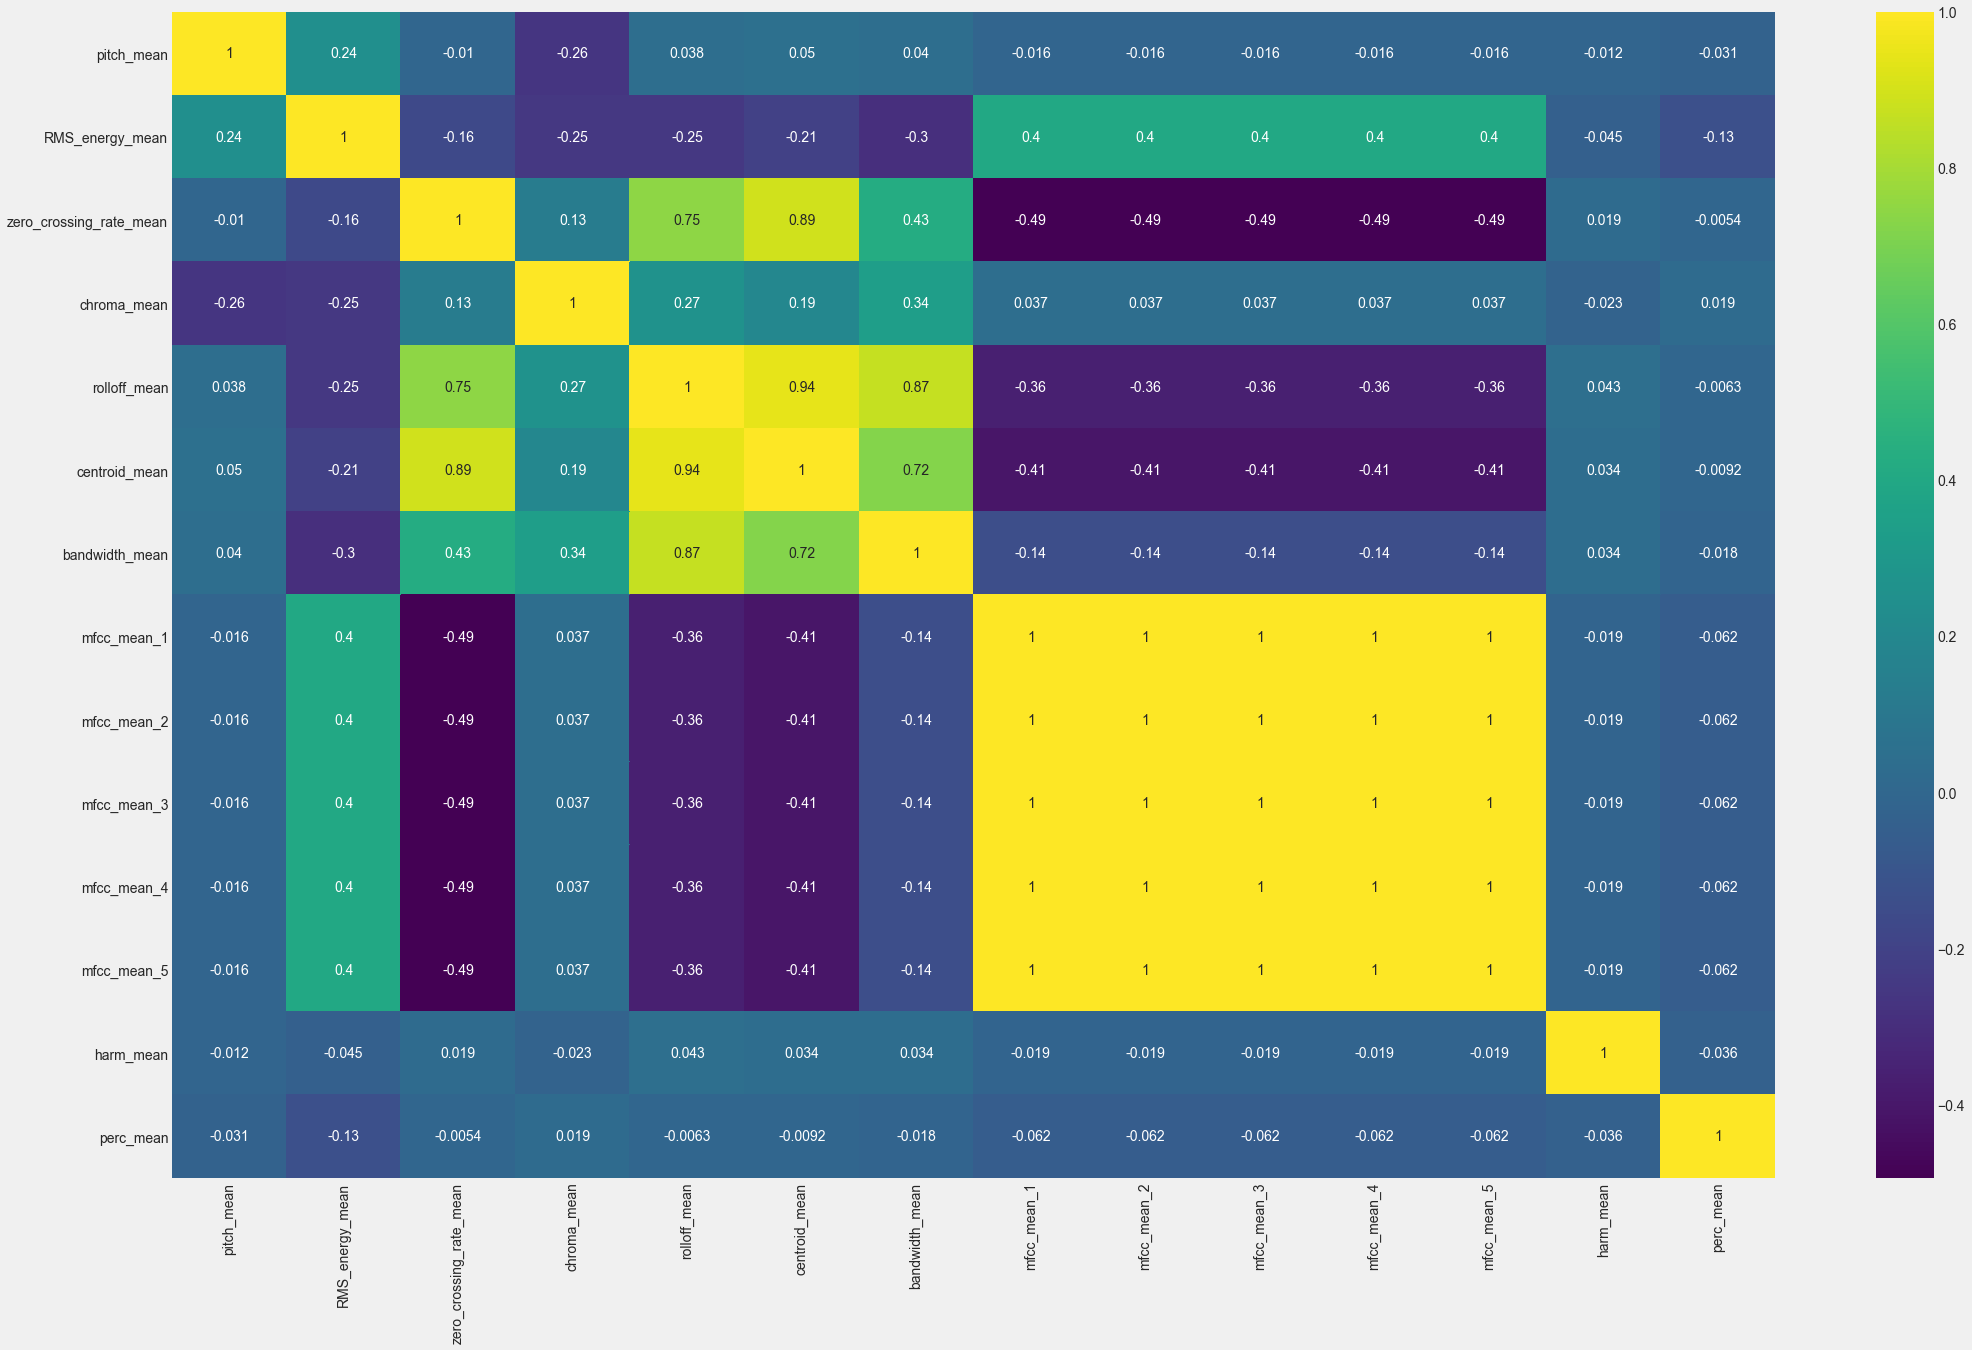

In [211]:
# Computing the Correlation Matrix
spike_cols = [col for col in all_features_df.columns if 'mean' in col or 'label' in col]
corr_data = all_features_df[spike_cols].corr()
plt.figure(figsize=(32, 20))
sns.set_style('ticks')
sns.heatmap(corr_data, cmap='viridis',annot=True)
plt.show()

Notice how the mfcc features are correlated.

## Preprocessing.

There are two major scaling method:
- Normalization
- Standardization

Since I am using SVM with kernel `RBF` kernel, it is essential to standardize the data, because the algorithm assumes that all features are centered around 0 and have variance in the same order.

I am using Principal component Analysis (PCA) to reduce dimensionality to 2, so we can plot the predictor space.

In [212]:
# Standardize features by removing the mean and scaling to unit variance
standard_scaler = preprocessing.StandardScaler()
scaled_x = standard_scaler.fit_transform(predictors)

# Use PCA 2 components to visualize all the data
pca = PCA(n_components=2)
pca_x = pca.fit_transform(scaled_x)
pcaX_df = pd.DataFrame(data = pca_x, columns = ['x1', 'x2'])

print(f"Total features utilization in the resulted two PCA components : {np.sum(pca.explained_variance_ratio_)}")

Total features utilization in the resulted two PCA components : 0.5294897445354441


In [213]:
def plot_predictor_space(x1: pd.DataFrame, x2: pd.DataFrame, y: pd.DataFrame, title: str):
    np_x1 = x1.to_numpy()
    np_x2 = x2.to_numpy()
    plt.figure(figsize=(6, 6))
    plt.scatter(np_x1[y==0], np_x2[y==0], s=50 , color= '#FF0000', label='{:d} ({:s})'.format(0, 'Male'))
    plt.scatter(np_x1[y==2], np_x2[y==2], s=50 , color= '#0000FF', label='{:d} ({:s})'.format(2, 'Female'))
    plt.title(title)
    plt.legend(fontsize=12)
    plt.xlabel(x1.columns[0], fontsize=14)
    plt.ylabel(x2.columns[0], fontsize=14)
    plt.xlim(np.min(np_x1)-0.1,np.max(np_x1)+0.1)
    plt.ylim(np.min(np_x2)-0.1,np.max(np_x2)+0.1)
    plt.grid(True)
    plt.show()

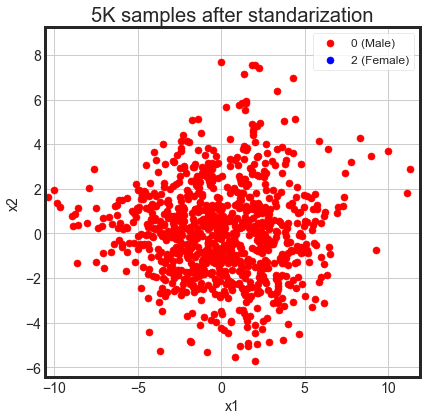

In [214]:
plot_predictor_space(pcaX_df[['x1']], pcaX_df[['x2']], labels, '5K samples after standarization')

Let's plot a 500 random sample for better visualization

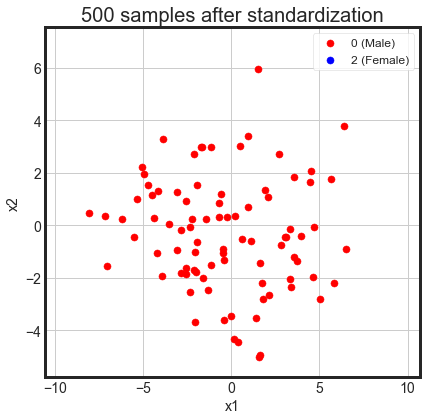

In [215]:
scaled_data = pd.concat([pcaX_df, labels], axis = 1)
random_sample_data = scaled_data.sample(n=500, replace=False)
plot_predictor_space(random_sample_data[['x1']], random_sample_data[['x2']], random_sample_data[[LABEL_COLUMN]],
                     '500 samples after standardization')

## Model description
I will be using  <font color=green>Label Spreading</font> model for semi-supervised learning.

## Training and validation

For the first approach, we are splitting data to labeled and unlabeled.

Then a small subset of the labeled data (40%) will be used as labeled, the rest will be set unlabeled.

We then perform standardization on the labeled subset alone, and fit the Label Spreading model with the two subset. We can evaluate the accuracy since we actually have the true labels of the pretended unlabeled subset.

We then use the fitted model to predict the unlabeled data.



In [216]:
rng = np.random.RandomState(0)

# first we work with labeled data only
labeled_data = labeled_np

X = labeled_data[:, 1:]
y = labeled_data[:, 0]

n_total_samples = len(y)

# number of samples to be used as labeled
n_labeled_samples = int(0.4 * n_total_samples)

# indecies of unlabeled samples
unlabeled_indices = np.arange(n_total_samples)[n_labeled_samples:]

# save a copy of the true labels
# then reset the indecies of samples to be used as unlabeled -1
y_train = np.copy(y)
y_train[unlabeled_indices] = -1

# standardize predictors first
scaler = preprocessing.StandardScaler()
scaledX = scaler.fit_transform(X)
lp_model = LabelSpreading(gamma=0.25, max_iter=20)
print('fitting model ...')
lp_model.fit(scaledX, y_train)

# get predicted labels for the presumed unlabeled subset
predicted_labels = lp_model.transduction_[unlabeled_indices]
# get the true labels of the presumed unlabeled subset
true_labels = y[unlabeled_indices]

accuracy = np.mean(true_labels==predicted_labels)
print(f'Accuracy : {accuracy}')
X_unlabeled = unlabeled_np[:, 1:]
scaledX_unlabeled = scaler.fit_transform(X_unlabeled)
y_pred_unlabeled = lp_model.predict(scaledX_unlabeled)
print(f'Predicted {len(y_pred_unlabeled)} unlabeled audios.')

fitting model ...
Accuracy : 0.39669421487603307
Predicted 3185 unlabeled audios.


## Performance evaluation

Since this is a semi supervised problem, we can evaluate the supervised part.
So here is the confusion matrix and classification report of classifying the labeled portion using Label Spreading.

Unfortunately, for the unlabeled part, we can't really evaluate it, unless we obtain true labels.
We can of course take a subset of the predicted labels of unlabeled data, inspect their audios, for manual evaluation. I won't recommend it labeling 1800 audio was already exhausting.

However, the accuracy from the supervised training should be an indicator of how the model will eb able to perform  labeling the unlabeled data.

Another note, although this is a binary classification case, we cannot used the ROC curve since we need true labels.

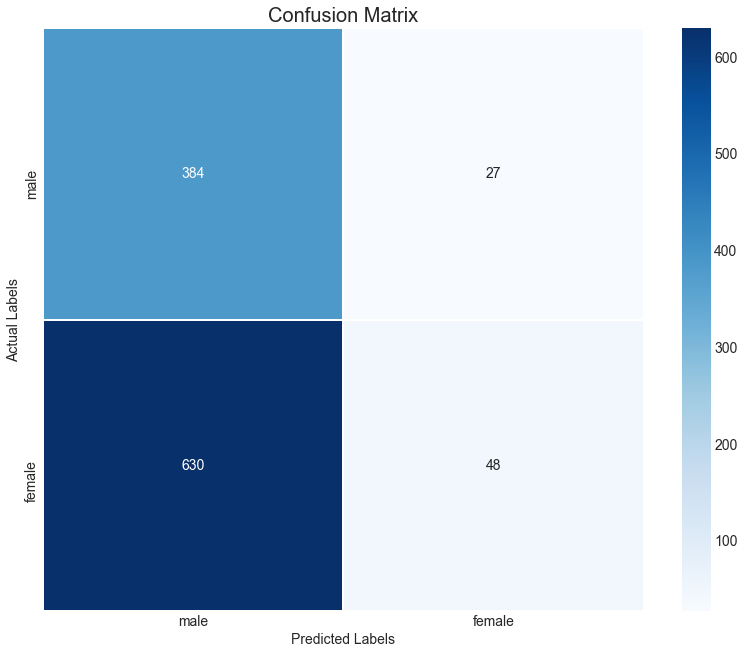

              precision    recall  f1-score   support

         0.0       0.38      0.93      0.54       411
         1.0       0.64      0.07      0.13       678

    accuracy                           0.40      1089
   macro avg       0.51      0.50      0.33      1089
weighted avg       0.54      0.40      0.28      1089



In [217]:

plt.figure(figsize=(12, 10))

cm = confusion_matrix(true_labels, predicted_labels)
cm = pd.DataFrame(cm , index = [i for i in GENDER_LABELS] , columns = [i for i in GENDER_LABELS])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

print(classification_report(true_labels, predicted_labels))


## Conclusions

We achieved 40% accuracy, which is a poor one, and cannot depend on the model to label the rest, although the goal of the semi learning classification is make use of little amount of labeled data. But, we probably need more data to achieve higher accuracy.


Kaggle kernels that helped me in this project:

https://www.kaggle.com/kashnitsky/topic-2-visual-data-analysis-in-python

https://www.kaggle.com/andradaolteanu/work-w-audio-data-visualise-classify-recommend

https://scikit-learn.org/stable/auto_examples/semi_supervised/plot_label_propagation_digits.html#sphx-glr-auto-examples-semi-supervised-plot-label-propagation-digits-py